In [463]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import skimage

import pywt
from sklearn.cluster import KMeans
from skimage import morphology, color, img_as_ubyte
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage import measure

In [464]:
!ls DRIVE/training/images

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [465]:
!ls DRIVE/training/mask
# We are not using masks because we can generate them using OTSU ourselves too for ROI

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [466]:
!ls DRIVE/training/1st_manual

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [467]:
IMG_INDEX=21

### Reading image

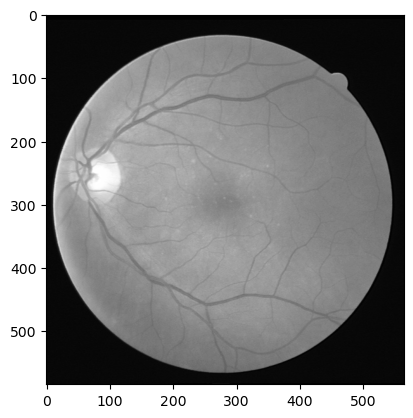

In [468]:
img = cv.imread(f"DRIVE/training/images/{IMG_INDEX}_training.tif")
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap="gray")

## Pre-processing

### Green channel extraction

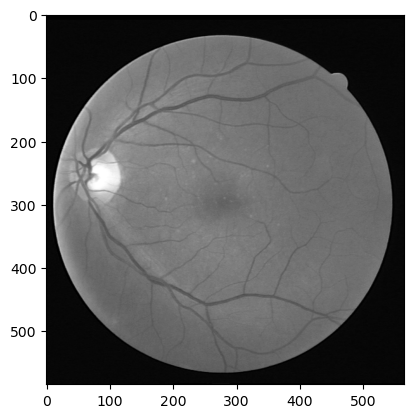

In [469]:
b, g, r = cv.split(img)
img_green = g
plt.imshow(img_green, cmap="gray")

### CLAHE Histogram Equalisation

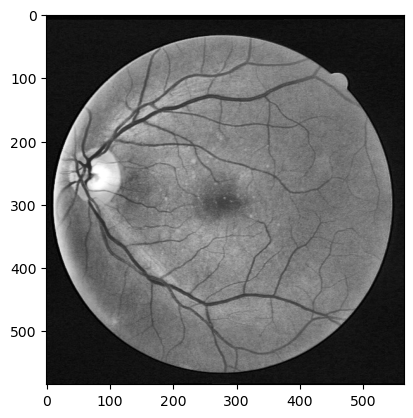

In [470]:
clahe = cv.createCLAHE(clipLimit=2.55)
img_clahe = clahe.apply(img_green)
plt.imshow(img_clahe, cmap="gray")

### ROI Extraction (OTSU)

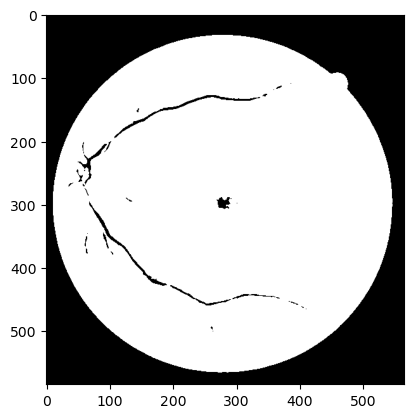

In [471]:
blur = cv.GaussianBlur(img_clahe,(5,5),0)
_,mask = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
plt.imshow(mask, cmap="gray")

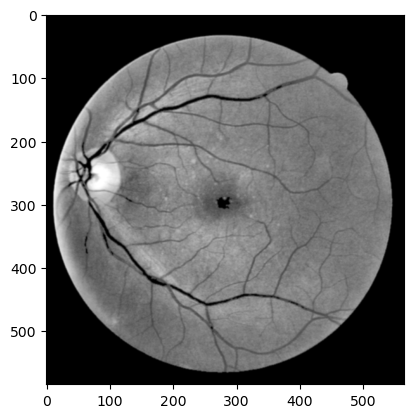

In [472]:
img_mask = cv.bitwise_and(img_clahe,img_clahe, mask=mask)
img_mask = cv.GaussianBlur(img_mask, (3,3), 0)
plt.imshow(img_mask, cmap="gray")

### Image Normalization
Note: The image does not change after normalisation with (0, 255) because CLAHE already does that. If we reduce the normalisation limit to (0, 127) we will observe a difference

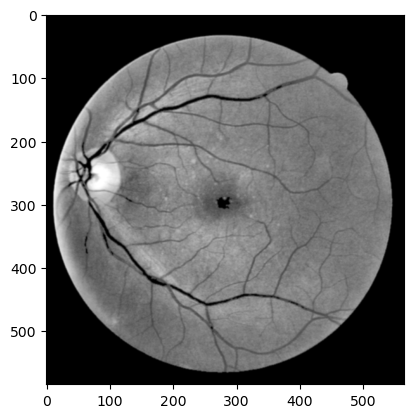

In [473]:
img_norm = cv.normalize(img_mask, None, 0, 255, cv.NORM_MINMAX)
plt.imshow(img_norm, cmap="gray")

### Morphological Transform (Image Opening)
Image opening is erosion followed by dilusion

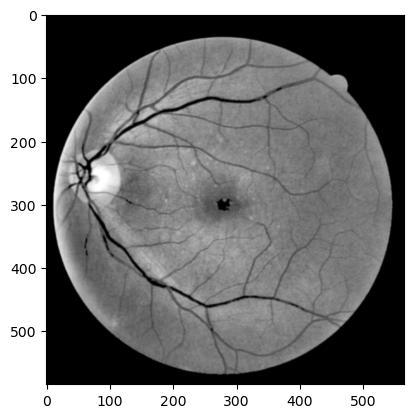

In [474]:
img_erode1 = cv.erode(img_norm, (3,3))
img_open1 = cv.dilate(img_erode1, (3,3))
img_erode2 = cv.erode(img_open1, (5,5))
img_open2 = cv.dilate(img_erode2, (5,5))
img_erode3 = cv.erode(img_open2, (7,7))
img_open3 = cv.dilate(img_erode3, (7,7))
plt.imshow(img_open3, cmap="gray")

## Blood Vessel Enhancement (BVE)

### Frangi Filtering

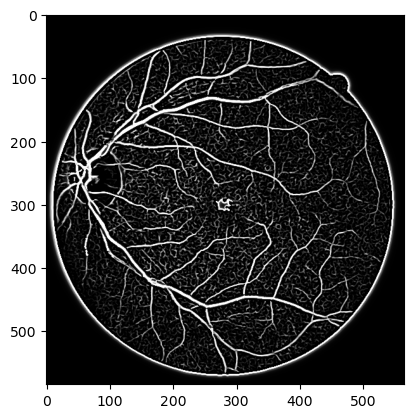

In [475]:
img_frangi = skimage.filters.frangi(img_open3, beta=2, gamma=3.5)
img_frangi = skimage.util.img_as_ubyte(img_frangi)
plt.imshow(img_frangi, cmap="gray")

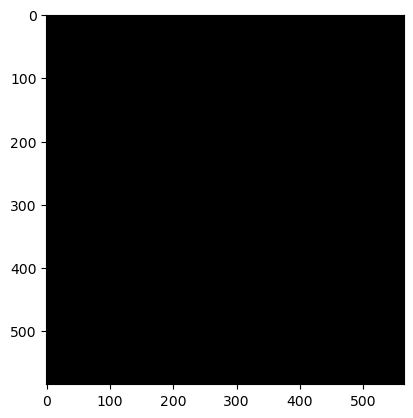

In [476]:
def modified_tophat_transform(image, closing_element, opening_element):
    # Apply morphological closing with the closing element
    closed_image = cv.morphologyEx(image, cv.MORPH_CLOSE, closing_element)

    # Apply morphological opening with the opening element
    opened_image = cv.morphologyEx(image, cv.MORPH_OPEN, opening_element)

    # Compute the modified top-hat transform
    itophat = cv.subtract(image, closed_image)

    return itophat

# Define structuring elements for closing and opening
closing_element = cv.getStructuringElement(cv.MORPH_ELLIPSE, (15, 15))
opening_element = cv.getStructuringElement(cv.MORPH_ELLIPSE, (15, 15))

# Apply modified top-hat transform
itophat_transformed = modified_tophat_transform(img_frangi, closing_element, opening_element)

plt.imshow(itophat_transformed, cmap="gray")

## Post Processing

### Noise reduction
We find contours then remove small components less than 500 in area

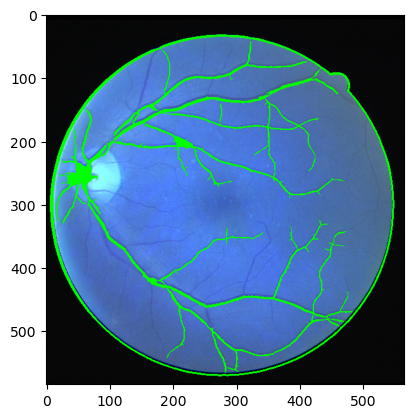

In [477]:
_, img_bw = cv.threshold(img_frangi, 0, 255 ,cv.THRESH_BINARY+cv.THRESH_OTSU)
contours, _ = cv.findContours(img_bw, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

areas = []
ok = []
for contour in contours:
    area = cv.contourArea(contour)
    if area > 500:
        areas.append(area)
        ok.append(contour)

img_test = cv.imread("DRIVE/training/images/21_training.tif")
cv.drawContours(img_test, ok, -1, (0,255,0), cv.FILLED)
plt.imshow(img_test, cmap="gray")

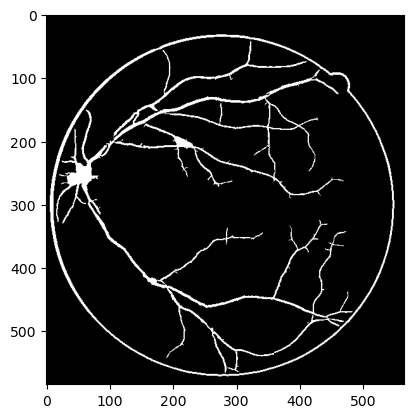

In [478]:
out = np.zeros(img.shape, dtype=np.uint8)
out = cv.cvtColor(out, cv.COLOR_BGR2GRAY)

cv.drawContours(out, ok, -1, (255,255,255), cv.FILLED)
_, out = cv.threshold(out, 0, 255, cv.THRESH_BINARY)
plt.imshow(out, cmap="gray")

### Outer circle removal (Boundary removal)
We observed the mask result is not supposed to have the outer circle.

This outer circle would come in most edge detection methods because it is an edge between the background and the retina, hence, we will remove this by creating a circular mask around the eye and cropping the rest out.

This mask is created by eroding the previous mask

Boundary = A - A(-)B

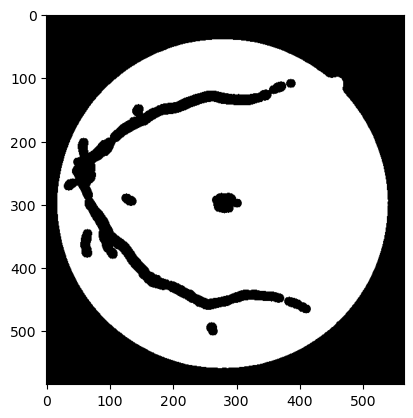

In [479]:
mask_eroded = cv.erode(mask, cv.getStructuringElement(cv.MORPH_ELLIPSE, (15, 15)))
# mask_eroded1 = cv.imread(r"C:\Users\harsh\Desktop\ELL 715\ELL715\project\mask.jpg")
# mask_eroded = cv.cvtColor(mask_eroded1, cv.COLOR_BGR2GRAY)
# print(img1.shape)
plt.imshow(mask_eroded, cmap="gray")

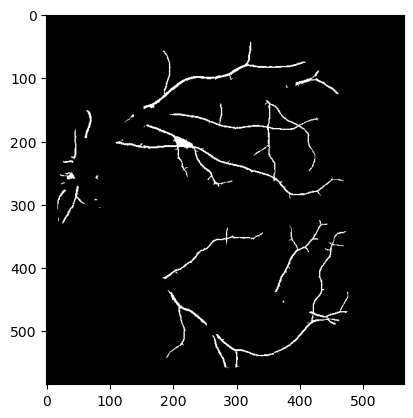

In [480]:
img_masked = cv.bitwise_and(out,out, mask=mask_eroded)
plt.imshow(img_masked,cmap="gray")

In [481]:
cv.imwrite(f"results/final_{IMG_INDEX}.jpg", img_masked)

True

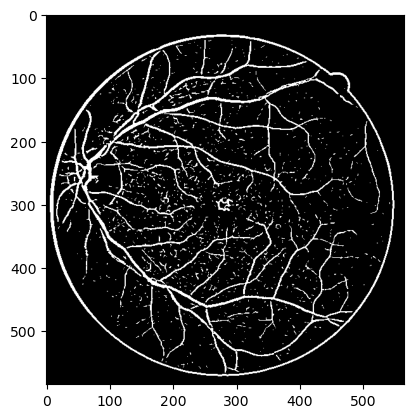

In [482]:
def multilevel_otsu_thresholding(gray_image, levels):
    thresholds = []
    for _ in range(levels - 1):
        _, threshold = cv.threshold(gray_image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
        thresholds.append(threshold)
        gray_image = cv.bitwise_and(gray_image, cv.bitwise_not(threshold))

    _, last_threshold = cv.threshold(gray_image, 0, 255, cv.THRESH_BINARY)
    thresholds.append(last_threshold)

    return thresholds

num_levels = 2 

thresholds = multilevel_otsu_thresholding(img_frangi, num_levels)


plt.imshow(thresholds[0], cmap="gray")

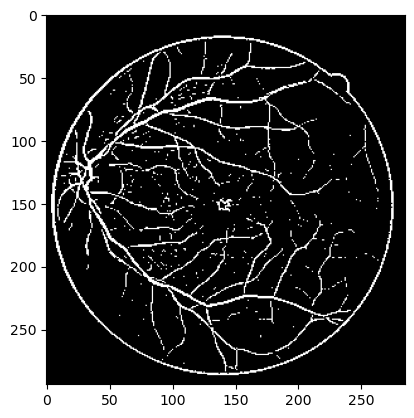

In [483]:
def wavelet_segmentation(image):
    coeffs2 = pywt.dwt2(image, 'bior1.3')
    cA, (cH, cV, cD) = coeffs2
    details = cA
    # print(np.abs(details))
    _, details_thresholded = cv.threshold(np.abs(details), 255, 255, cv.THRESH_BINARY)

    return details_thresholded

thick_vessels = wavelet_segmentation(img_frangi)
plt.imshow(thick_vessels, cmap="gray")

c:\Users\harsh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


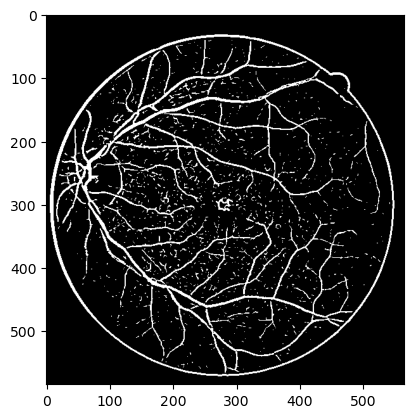

In [484]:
def kmeans_segmentation(image):
    image1 = np.float32(image)
    flattened_image = image1.flatten().reshape(-1, 1)

    kmeans = KMeans(n_clusters=2, random_state=1)
    kmeans.fit(flattened_image)
    segmented_image = kmeans.labels_.reshape(image.shape)
    # np.float32(segmented_image)
    segmented_image = cv.convertScaleAbs(segmented_image)
    # print(segmented_image)
    _, details_thresholded = cv.threshold(segmented_image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    return details_thresholded

def post_process(image):
    # Remove small objects
    image_cleaned = morphology.remove_small_objects(image, min_size=50)

    # Perform morphological operations
    image_processed = morphology.binary_closing(image_cleaned, morphology.disk(5))
    image_processed = morphology.binary_opening(image_processed, morphology.disk(5))

    return image_processed

thin_vessels = kmeans_segmentation(img_frangi)
plt.imshow(thin_vessels, cmap="gray")

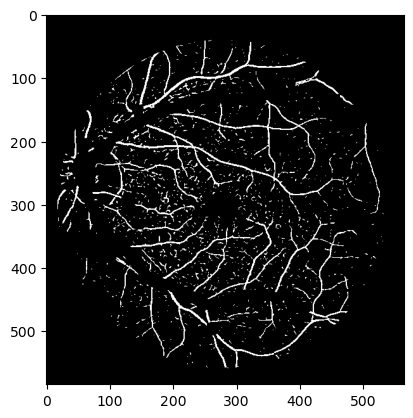

In [485]:
img_masked1 = cv.bitwise_and(thin_vessels,thin_vessels, mask=mask_eroded)
plt.imshow(img_masked1,cmap="gray")

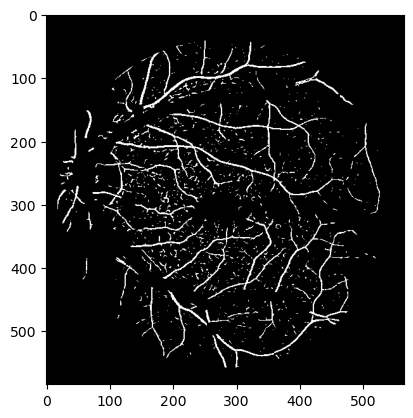

In [486]:
labeled_image = measure.label(img_masked1, connectivity=2)
# print(np.unique(labeled_image))
regions = measure.regionprops(labeled_image)

result_image = np.zeros_like(img_masked1)

for region in regions:
    minr, minc, maxr, maxc = region.bbox
    # print(region.area)
    if region.area > 6:  
        result_image[minr:maxr, minc:maxc] = img_masked1[minr:maxr, minc:maxc]

plt.imshow(result_image, cmap="gray")

## Result

### Our prediction

In [487]:
def calculate_metrics(image1, image2):

    _, image1_binary = cv.threshold(image1, 127, 255, cv.THRESH_BINARY)
    _, image2_binary = cv.threshold(image2, 127, 255, cv.THRESH_BINARY)

    tp = np.sum(np.logical_and(image1_binary == 255, image2_binary == 255))
    tn = np.sum(np.logical_and(image1_binary == 0, image2_binary == 0))
    fp = np.sum(np.logical_and(image1_binary == 0, image2_binary == 255))
    fn = np.sum(np.logical_and(image1_binary == 255, image2_binary == 0))

    accuracy = (tp + tn) / (tp + tn + fp + fn)

    return tp, tn, fp, fn, accuracy

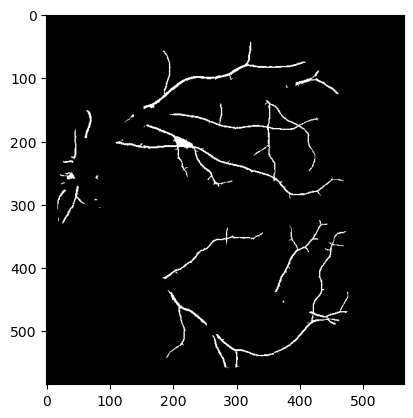

In [488]:
predicted = img_masked
plt.imshow(predicted, cmap="gray")

### Given actual value

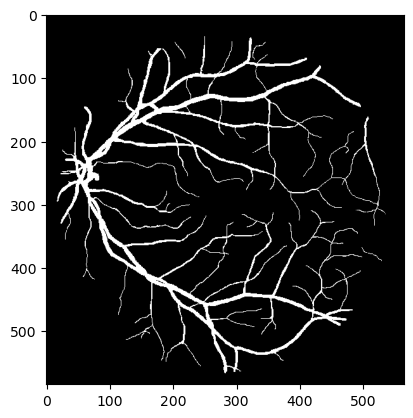

In [489]:
cap = cv.VideoCapture(f"DRIVE/training/1st_manual/{IMG_INDEX}_manual1.gif")
_, actual = cap.read()
actual = cv.cvtColor(actual, cv.COLOR_BGR2GRAY)
_, actual = cv.threshold(actual, 0, 255, cv.THRESH_BINARY)

plt.imshow(actual, cmap="gray")

In [490]:
np.sum(predicted >=0)

329960

In [491]:
np.sum(actual == predicted)

303327

In [492]:
tp, tn, fp, fn, accuracy = calculate_metrics(actual, predicted)

print(f"True Positive: {tp}")
print(f"True Negative: {tn}")
print(f"False Positive: {fp}")
print(f"False Negative: {fn}")
print(f"Accuracy: {accuracy * 100:.2f}%")

True Positive: 3224
True Negative: 300103
False Positive: 5199
False Negative: 21434
Accuracy: 91.93%


## Analysis

We got same output in **286386 out of 329960 pixels (86.79%)**
